# Assignment 1
# Data Pipelines & Data Analytics Life Cycle
# Forecasting the Wind Power Production in Orkney

#### Environment and Libraries

### Setting up the environment with `venv`

It is always recommended to create a new environment for any new project to avoid dependency issues and keep a clean working space. 

Step 1: Create a virtual environment in your project directory:

python3 -m venv .venv


Step 2: Activate the virtual environment:  
For Linux/Mac:  
source .venv/bin/activate  


For Windows:  
.venv\Scripts\activate  


Step 3: Install the influxdb and MLFlow libraries using requirements.txt from https://github.itu.dk/Large-Scale-Data-Analysis-2025/python_env

pip install -r requirements.txt

Once your environment is set up and dependencies are installed, you are ready to proceed with your project.



### Imports

In [ ]:
# You absolutely need these
from influxdb import InfluxDBClient
import mlflow

# You will probably need these
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline

# This are for example purposes. You may discard them if you don't use them.
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from mlflow.models import infer_signature
from urllib.parse import urlparse

### TODO -> HERE YOU CAN ADD ANY OTHER LIBRARIES YOU MAY NEED ###

In [ ]:
%matplotlib widget

## Step 1: The Data

### Getting the data with InfluxDB

The data is stored in an [InfluxDB](https://www.influxdata.com/), which is a non-relational time-series database. InfluxDB can be queried using [InfluxQL](https://docs.influxdata.com/influxdb/v1.8/query_language/spec/), a "SQL-like" query language for time-series data. InfluxDB does not have tables with rows and columns, instead data is stored in measurements with fields and tags. <br><br>
**NOTE:** <em>You don't need to know much about InfluxDB syntax, but if you are interested, feel free to browse around the [documentation](https://docs.influxdata.com/).</em>

The data for this assignment is stored in a database, with one table for the weather data and another for the power generation data. To do this, we first need to create an instance of the InfluxDB Client, that will allow us to query the needed data. Let's see how this is done.

In [ ]:
from influxdb import InfluxDBClient

# Set the needed parameters to connect to the database
### THIS SHOULD NOT BE CHANGED ###
settings = {
    'host': 'influxus.itu.dk',
    'port': 8086,
    'username': 'lsda',
    'password': 'icanonlyread'
    }

# Create an InfluxDB Client instance and select the orkney database
### YOU DON'T NEED TO CHANGE ANYTHING HERE ###
client = InfluxDBClient(host=settings['host'], port=settings['port'], username=settings['username'], password=settings['password'])
client.switch_database('orkney')

As explained before, InfluxDB uses InfluxQL, a "SQL-like" syntax. We will use this to select the data we need from the correspondant tables, using our client instance. Then we can use an auxiliary function to convert the resulting set from the query into a Pandas Dataframe, making it easier to work with.<br><br>
**NOTE:** <em>If you are curious to see how the resulting set from InfluxDB looks like, you can avoid using this function and printing the result.</em>

In [ ]:
## Function to tranform the InfluxDB resulting set into a Dataframe
### YOU DON'T NEED TO CHANGE ANYTHING HERE ###
def set_to_dataframe(resulting_set):
    
    values = resulting_set.raw["series"][0]["values"]
    columns = resulting_set.raw["series"][0]["columns"]
    df = pd.DataFrame(values, columns=columns).set_index("time")
    df.index = pd.to_datetime(df.index) # Convert to datetime-index

    return df

Now we are ready to retrieve the data.<br><br>
Let's suppose we want the power generation and wind data from the last 90 days:

In [ ]:
days = 90 # -> You can change this to get any other range of days

### YOU DON'T NEED TO CHANGE ANYTHING HERE ###
power_set = client.query(
    "SELECT * FROM Generation where time > now()-"+str(days)+"d"
    ) # Query written in InfluxQL. We are retrieving all generation data from 90 days back.

# Get the last 90 days of weather forecasts with the shortest lead time
wind_set  = client.query(
    "SELECT * FROM MetForecasts where time > now()-"+str(days)+"d and time <= now() and Lead_hours = '1'"
    ) # Query written in InfluxQL. We are retrieving all weather forecast data from 90 days back and with 1 lead hour.

power_df = set_to_dataframe(power_set)
wind_df = set_to_dataframe(wind_set)
# power_df.to_csv('power_df.csv')
# wind_df.to_csv('wind_df.csv')
# power_df = pd.read_csv('power_df.csv', index_col='time')
# wind_df = pd.read_csv('wind_df.csv', index_col='time')

In [ ]:
# print rows with missing values

<font size="2">**NOTE:** <em>You don't need to change the query syntax, but it is useful if you try to make sense out of it.</em> </font>

Let's take a look at the resulting dataframes:

In [ ]:
power_df.tail()

In [ ]:
# print the hour timedeltas between subsequent rows
power_df[:1000].index.to_series().transform(lambda x: pd.to_datetime(x))

In [ ]:
wind_df.head()

In [ ]:
wind_df.tail()

In [ ]:
plt.figure()
plt.plot(power_df.iloc[:1000].index, power_df.iloc[:1000]['ANM'])
plt.plot(power_df.iloc[:1000].index, power_df.iloc[:1000]['Total'])
plt.plot(power_df.iloc[:1000].index, power_df.iloc[:1000]['Non-ANM'])
# don't print x labels
plt.xticks([])
plt.show()

**NOTE:** <em>This table contains three columns, but closer inspection will reveal a very straigh relationship between those three. Can you spot that?<br>
We are clearly interested in the total power generation, regardless of the source type.</em>

In [ ]:
wind_df.shape

In [ ]:
wind_df.tail()

In [ ]:
plt.figure()
plt.plot(wind_df.iloc[:1000].index, wind_df.iloc[:1000]['Speed'])
plt.show()

**NOTE:** <em>This table contains four columns, but lead hours and source time are irrelevant here. Can you think why?</em>

**NOTE:** <em>Look at the table's index. Do both data sources contain the same intervals? And if not, what problems could arise when merging the data?</em>

### Merging the data sources

We have two dataframes, one with weather forecast and one with power generation. To do some analysis on the relationship between these two datasets, it might be useful to join (and align) the data.

#### Example

In [ ]:
# Joining the data
joined_dfs = power_df.join(wind_df, how="inner")

Joining the two datasets with an inner join means keeping only those records that match their index. Although this will work, you may notice that most of our data is discarded due to the unmatching time intervals. You may want to explore other possible ways to merge the data.

In [ ]:
### TODO -> JOIN THE TWO DATASETS ###

### Understanding the data: EDA

It can be also useful to plot our datasets to see what relationships they might hold.

In [ ]:
# Subplots
fig, ax = plt.subplots(1,3, figsize=(25,4))

# Speed and Power for the last 7 days
ax[0].plot(joined_dfs["Speed"].tail(int(7*24/3)), label="Speed", color="blue") # Since the datasets are joined every three hours, we need the last 7 days times 24 hours diveded by 3 hours
ax[0].plot(joined_dfs["Total"].tail(int(7*24/3)), label="Power", color="tab:red") # Since the datasets are joined every three hours, we need the last 7 days times 24 hours diveded by 3 hours
ax[0].set_title("Windspeed & Power Generation over last 7 days")
ax[0].set_xlabel("Time")
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_ylabel("Windspeed [m/s], Power [MW]")
ax[0].legend()

# Speed vs Total (Power Curve nature)
ax[1].scatter(joined_dfs["Speed"], joined_dfs["Total"])
power_curve = joined_dfs.groupby("Speed").median(numeric_only=True)["Total"]
ax[1].plot(power_curve.index, power_curve.values, "k:", label="Power Curve")
ax[1].legend()
ax[1].set_title("Windspeed vs Power")
ax[1].set_ylabel("Power [MW]")
ax[1].set_xlabel("Windspeed [m/s]")

# Speed and Power per Wind Direction
wind_grouped_by_direction = joined_dfs.groupby("Direction").mean(numeric_only=True).reset_index()
bar_width = 0.5
x = np.arange(len(wind_grouped_by_direction.index))

ax[2].bar(x, wind_grouped_by_direction.Total, width=0.5, label="Power", color="tab:red")
ax[2].bar(x + bar_width, wind_grouped_by_direction.Speed, width=0.5, label="Speed", color="blue")
ax[2].legend()
ax[2].set_xticks(x)
ax[2].set_xticklabels(wind_grouped_by_direction.Direction)
ax[2].tick_params(axis='x', labelrotation = 45)
ax[2].set_title("Speed and Power per Direction");

plt.show()


# create a difference plot
plt.figure()

y = wind_grouped_by_direction.Total / wind_grouped_by_direction.Speed

plt.bar(wind_grouped_by_direction.Direction, y)
# plot horizontal, a mean of y
plt.axhline(y.mean(), color='r', linestyle='-')
plt.show()

# print standard deviation of y
y.std()

In [ ]:
joined_dfs.head()

In [ ]:
joined_dfs

In [ ]:
joined_dfs.shape
print(joined_dfs['Direction'].unique().size)

In [ ]:
# Additional two plots:
# Convert wind direction into categorical variable, and then plot the points given its three top principal components,
# with color intensity given by the power generated.
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

# One hot encode the wind direction
encoder = OneHotEncoder(sparse_output=False)
encoded_directions = encoder.fit_transform(joined_dfs[['Direction']])

# Perform PCA to reduce dimensionality
pca = PCA(n_components=3)
principal_components = pca.fit_transform(encoded_directions)

# Create a new DataFrame with the principal components and power generation
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
pca_df['Power'] = joined_dfs['Total'].values
pca_df.drop_duplicates(subset=['PC1', 'PC2', 'PC3'],inplace=True)

# Plot the points given its three top principal components, with color intensity given by the


In [ ]:
encoder = OneHotEncoder(sparse_output=False)
encoded_directions = encoder.fit_transform(wind_df[['Direction']])

In [ ]:
%matplotlib widget

In [ ]:
pca_df.shape

In [ ]:
# print explained variability by each of the first three principal components

# do 3d plot of the first three principal components

import matplotlib.pyplot as plt

# Ensure interactive plotting
plt.ion()

# Create rotatable 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
# o = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap="tab10", alpha=0.5)
o = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], alpha=0.5)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.legend(*o.legend_elements(), title="Classes")

ax.view_init(10, 40)


# Show the plot
plt.show()


# ACTUALLY, is there any sense to do PCA of categorical variables? I'm feeling that it's not the case. I'm not sure

In [ ]:
# It doesn't make any sense to do PCA by default. To verify, but that's what I'm going to write in the report.

In [ ]:
pca_df.describe()

In [ ]:
# count unique rows, given the first three principal components
pca_df.drop_duplicates(subset=['PC1', 'PC2', 'PC3']).shape

In [ ]:
# plot each of components against each other using subplots
fig, ax = plt.subplots(1, 3
                       )

for i, component in enumerate(['PC1', 'PC2', 'PC3']):
    ax[i].scatter(pca_df[component], pca_df['Power'], alpha=0.5)
    ax[i].set_xlabel(component)
    ax[i].set_ylabel('Power')
    
plt.show()

In [ ]:
# print rows with empty values
joined_dfs[joined_dfs.isnull().any(axis=1)]

In [ ]:
joined_dfs.head()

In [ ]:
# I'm not sure how to interpret this plot honestly. Saying that:
# constant = wind_grouped_by_direction.Total / wind_grouped_by_direction.Speed helps anything, I'm not sure.

In [ ]:
# From that plot one could see that given an average windspeed, one could predict average power output, without considering the wind direction.
# which suggests maybe it's not that important to consider wind direction in the model.
# actually, a statistical test could be performed, because if these are means, these are normally distributed, and we could perform a t-test to see if the means are different.
# so their ratio is distributed as cauchy, so can check that later.

In [ ]:
# Another check in determining the importance of wind direction is checking the correlation between wind direction and speed.abs
# Also, another one would be just plotting windspeed given different directions (using colouring) and see if there's any difference in pattern
# perhaps would be the best to draw them one vs one, but there would be 25 combinations, so that's a lot of plots.

# let's check the correlation between wind direction and speed.abs on wind_df

one_hot_encoded = pd.get_dummies(wind_df['Direction'])

# compute the correlation between wind speed and each of the one-hot encoded wind directions
correlations = one_hot_encoded.apply(lambda x: wind_df['Speed'].corr(x))
correlations


In [ ]:
# convert wind directions to radians. Now it's categorical like E, W, N, S, ENE, ESE etc.
# so we need to convert them to degrees to be able to plot them on a circle.
# we can use the following mapping:
converstion = {
    'N': 0,
    'NNE': 22.5,
    'NE': 45,
    'ENE': 67.5,
    'E': 90,
    'ESE': 112.5,
    'SE': 135,
    'SSE': 157.5,
    'S': 180,
    'SSW': 202.5,
    'SW': 225,
    'WSW': 247.5,
    'W': 270,
    'WNW': 292.5,
    'NW': 315,
    'NNW': 337.5
}

wind_df['Wx'] = wind_df['Direction'].transform(lambda x: np.cos(converstion[x] * np.pi / 180))
wind_df['Wy'] = wind_df['Direction'].transform(lambda x: np.sin(converstion[x] * np.pi / 180))
# if the values are close to 0, then make them 0
wind_df['Wx'] = wind_df['Wx'].transform(lambda x: 0 if abs(x) < 1e-10 else x)
wind_df['Wy'] = wind_df['Wy'].transform(lambda x: 0 if abs(x) < 1e-10 else x)
# now, these together repesent the unit vector of the wind direction

In [ ]:
# again: compute the correlation, and plot both Wx against Speed and Wy against Speed
correlations = wind_df[['Wx', 'Wy', 'Speed']].corr()
print(correlations)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(wind_df['Wx'], wind_df['Speed'])
ax[0].set_xlabel('Wx')
ax[0].set_ylabel('Speed')

ax[1].scatter(wind_df['Wy'], wind_df['Speed'])
ax[1].set_xlabel('Wy')
ax[1].set_ylabel('Speed')

plt.show()

In [ ]:
# checking co

In [ ]:
# how to encode these features?
# As radians: imo very wrong, it's just 'sparse' ordinal encoding, for nominal data. Bad idea, though dimensionality is the smallest.
# the second: one-hot encoding: I think could do fine, especially if some dimensionality reduction would be introduced. (PCA)
# the last one: as a vector. That sound interesting, because here it should encapsulate all the necessary information in the smallest dimensionality possible.
# Even though ordinality is introduced I guess it should be ounteracted by the ordinality of the second feature, so it should be fine.
# But I'm not super sure. I will write an email to my professor asap. Gonna try with these two. Obviously here scaling shall not be applied.

# Another issue: Should one scale categorical features? In my humble opinion, yes, because these still might have different variane - that's all.
# But I need to think / talk about it haha. By default I will leave them in fact but I would do other way. But not sure. I think it's still pretty much worth it.
# OK, let's think about it later.

In [ ]:
# https://web.archive.org/web/20220127105734/http://dr%C3%B8mst%C3%B8rre.dk/wp-content/wind/miller/windpower%20web/en/tour/wres/pwr.htm => super important!
# Pitfalls in Using Power Curves
# A power curve does not tell you how much power a wind turbine will produce at a certain average wind speed. You would not even be close, if you used that method!
# Remember, that the energy content of the wind varies very strongly with the wind speed, as we saw in the section on the energy in the wind. So, it matters a lot how that average came about, i.e. if winds vary a lot, or if the wind blows at a relatively constant speed.
# Also, you may remember from the example in the section on the power density function , that most of the wind energy is available at wind speeds which are twice the most common wind speed at the site.
# Finally, we need to account for the fact that the turbine may not be running at standard air pressure and temperature, and consequently make corrections for changes in the density of air.

In [ ]:
poly.get_feature_names_out()

In [ ]:
# poly features
from sklearn.preprocessing import PolynomialFeatures

# create polynomial features
poly = PolynomialFeatures(degree=3, include_bias=False, interaction_only=False)
poly.set_output(transform="pandas")
poly_features = poly.fit_transform(x)
poly_features

**NOTE:** <em>These plots should already give us an intuition of the different relationships between features. It seems clear that there is a positive relationship between the wind speed and the power generation from the turbines, as we obviously suspected. But that relationship is not completely linear. Can you spot that? Finally, it seems like the power generation also depends of where the winds is coming from. Maybe this could also be a useful feature.</em> 

In [ ]:
# How much data back: let's try 30, 90 days and 1 year back perhaps? Let's try with 90 days first and a year and then talk. For that I would just perform experiments
# haha :)
# More days means more data, but obviously in the past some other could be in place - I mean, climate change, global warming etc. Methaphorically speaking, data can 'expire'.

In order to plot the relationship between wind speed and power generation we have performed a very simple join with the two datasets. But since the intervals are not the same, a lot of data is discarded (<em>can you spot where in the code this happens?</em>). You may want to explore other ways to merge the data sources to minimize the loss of information.

In [ ]:
### TODO -> DO SOME EXTRA EDA ON THE DATA ###

# My Part

For each model:
1. Pull data (7, 90, a year). Log time. You can also log dataset haha, to have it as a point of reference. Log the dataset on its own :)
2. Drop missing and drop outliers. (I drop missing: enough data, drop outliers - standard procedure.) Check for missing
3. Do the cross val. For 7 days, use 4 weeks. For 90 years, use the whole year. For one year, use another year.
4. Encode features and scale them appropriately. Log the way it's been done haha, including info on them.
5. Output the score.


In [305]:
from wind_power.dataset import InfluxDBClientWrapper, get_power_and_wind_data
with InfluxDBClientWrapper() as client:
    power_df, wind_df, today = get_power_and_wind_data(client, days=250, date="2025-02-10")
power_df=power_df[['Total']]
joined_dfs = power_df.join(wind_df, how="right")

In [306]:
from darts import TimeSeries
from wind_power.features import robust_timeseries_imputer, DirectionEncodingTransformer


joined_dfs = robust_timeseries_imputer(joined_dfs)
joined_dfs = DirectionEncodingTransformer('vector').fit_transform(joined_dfs)
b = TimeSeries.from_dataframe(joined_dfs)

<string>:10: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
<string>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


In [307]:
from darts.models import VARIMA


a = VARIMA()
a.fit(b)

VARIMA(p=1, d=0, q=0, trend=None, add_encoders=None)

In [323]:
a.predict(30)

<TimeSeries (DataArray) (time: 30, component: 4, sample: 1)> Size: 960B
array([[[-0.81835044],
        [ 0.28259768],
        [ 7.74912582],
        [ 4.20918838]],

       [[-0.72504456],
        [ 0.19849614],
        [ 8.37633644],
        [ 4.38391116]],

       [[-0.64283811],
        [ 0.12834168],
        [ 8.7929555 ],
        [ 4.53698217]],

       [[-0.57056767],
        [ 0.07019814],
        [ 9.05823954],
        [ 4.66364391]],

...

       [[-0.06171424],
        [-0.13922161],
        [ 6.39476396],
        [ 3.6211306 ]],

       [[-0.05739733],
        [-0.13633376],
        [ 6.23340992],
        [ 3.53278297]],

       [[-0.05348585],
        [-0.13338988],
        [ 6.07467635],
        [ 3.44545849]],

       [[-0.04993609],
        [-0.13041155],
        [ 5.91869801],
        [ 3.35929634]]])
Coordinates:
  * time       (time) datetime64[ns] 240B 2025-02-10T03:00:00 ... 2025-02-13T...
  * component  (component) object 32B 'Wx' 'Wy' 'Total' 'Speed'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:

with InfluxDBClientWrapper() as client:
    power_df, wind_df, today = get_power_and_wind_data(
        client, days=250, date="2025-02-10"
    )

power_df = power_df[["Total"]]
wind_df.drop(columns=["Lead_hours", "Source_time"], inplace=True)

joined_dfs = power_df.join(wind_df, how="right")

pipeline = Pipeline(
    [
        ("impute", FunctionTransformer(robust_timeseries_imputer)),
        ("encode", DirectionEncodingTransformer("vector")),
        (
            "timeseries",
            FunctionTransformer(lambda df: TimeSeries.from_dataframe(df)),
        ),
        ("Model", VARIMA()),
    ]
)
print(pipeline.fit(joined_dfs).predict(30))



NameError: name 'Pipeline' is not defined

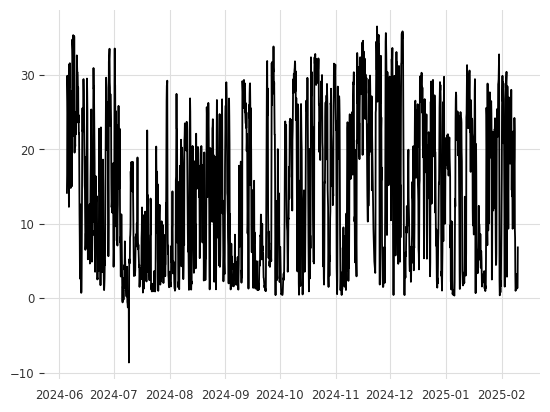

In [303]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(joined_dfs['Total'])
plt.show()

In [159]:
# power_df = pd.read_csv('./power_df.csv', index_col='time', usecols=['Total', 'time'])
# wind_df = pd.read_csv('./wind_df.csv', index_col='time')
power_df.head()
wind_df.head()

,Direction,Lead_hours,Source_time,Speed
time,,,,
2024-06-05 03:00:00+00:00,W,1,1717545600,9.83488
2024-06-05 06:00:00+00:00,W,1,1717556400,8.94080
2024-06-05 09:00:00+00:00,W,1,1717567200,11.17600
2024-06-05 12:00:00+00:00,W,1,1717578000,11.17600
2024-06-05 15:00:00+00:00,W,1,1717588800,9.83488


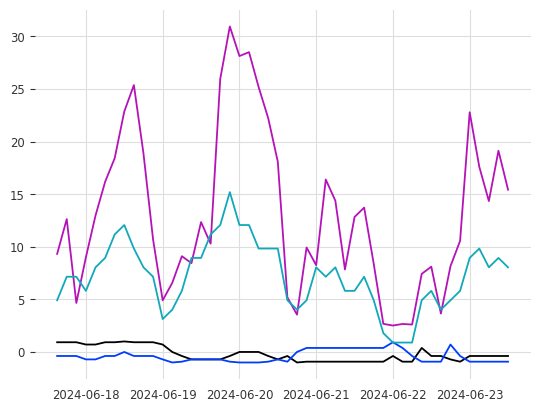

In [320]:
plt.figure()
plt.plot(joined_dfs.iloc[100:100+3*8*2])
plt.show()

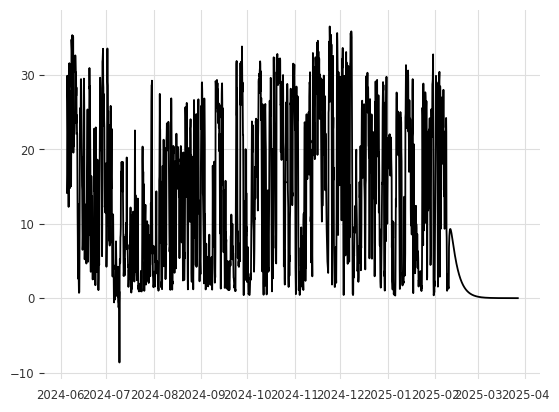

In [311]:
p=a.predict(360).pd_dataframe()['Total']
plt.figure()
plt.plot(pd.concat([joined_dfs['Total'], p]))
plt.show()

In [4]:
from wind_power.grid_search import pipe
pipe.named_steps['obtain_feats'].fit_transform(wind_df)

,direction__Wx,direction__Wy,speed_poly__Speed,speed_poly__Speed^2,speed_poly__Speed^3,direction__Wx_X_speed_poly__Speed,direction__Wx_X_speed_poly__Speed^2,direction__Wx_X_speed_poly__Speed^3,direction__Wy_X_speed_poly__Speed,direction__Wy_X_speed_poly__Speed^2,direction__Wy_X_speed_poly__Speed^3,bias
time,,,,,,,,,,,,
2024-12-07 15:00:00+00:00,1.000000e+00,0.000000,21.01088,441.457078,9275.401699,2.101088e+01,4.414571e+02,9.275402e+03,0.000000,0.000000,0.000000,1
2024-12-07 18:00:00+00:00,1.000000e+00,0.000000,19.22272,369.512964,7103.044247,1.922272e+01,3.695130e+02,7.103044e+03,0.000000,0.000000,0.000000,1
2024-12-07 21:00:00+00:00,1.000000e+00,0.000000,15.19936,231.020544,3511.364422,1.519936e+01,2.310205e+02,3.511364e+03,0.000000,0.000000,0.000000,1
2024-12-08 00:00:00+00:00,1.000000e+00,0.000000,12.96416,168.069445,2178.879170,1.296416e+01,1.680694e+02,2.178879e+03,0.000000,0.000000,0.000000,1
2024-12-08 03:00:00+00:00,1.000000e+00,0.000000,16.09344,258.998811,4168.181825,1.609344e+01,2.589988e+02,4.168182e+03,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-07 00:00:00+00:00,-7.071068e-01,-0.707107,12.07008,145.686831,1758.451708,-8.534835e+00,-1.030161e+02,-1.243413e+03,-8.534835,-103.016146,-1243.413127,1
2025-03-07 03:00:00+00:00,-7.071068e-01,-0.707107,16.09344,258.998811,4168.181825,-1.137978e+01,-1.831398e+02,-2.947350e+03,-11.379781,-183.139816,-2947.349634,1
2025-03-07 06:00:00+00:00,-1.836970e-16,-1.000000,15.19936,231.020544,3511.364422,-2.792077e-15,-4.243779e-14,-6.450272e-13,-15.199360,-231.020544,-3511.364422,1


## Step 2: Pipeline and data transformations

Now that we have our data, we need to construct the pipeline to process this data and pass it to our Machine Learning model. For this, you may find useful the Pipeline class from Scikit-Learn.

This class applies a list of transforms to your data, and pass the final state to an estimator (your model). Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods. The final estimator only needs to implement fit. 

The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. For this, it enables setting parameters of the various steps using their names and the parameter name separated by a '__'. 

You can find more information about Scikit-Learn's Pipeline [here](https://scikit-learn.org/stable/modules/compose.html#pipeline).

#### Example

In [ ]:
# A very basic pipeline
pipeline_example = Pipeline([
    # Transformations
    ("Scaler", StandardScaler()),
    # Estimator
    ("Linear Regression", LinearRegression())
])

In [ ]:
### TODO -> CREATE YOUR OWN PIPELINE ###
# Create your pipeline with the desired transformers
pipeline = Pipeline([

    # Transformer 1
    # Transformer 2
    # ...
    # Final estimator
])

In [ ]:
# 

## Evaluate your model

Now that you have a preprocessing pipeline ready, along with the final estimator, you may want to know how well your model performs. Choose the method you prefer, with special attention to the selected metric.

#### Example

In [ ]:
# Select our feature variables and our target variable.
joined_dfs = power_df.join(wind_df).dropna()

X = joined_dfs["Speed"].values.reshape(-1,1)
y = joined_dfs["Total"].values.reshape(-1,1)

# Split the data so we can test how well our model performs in unseen data
X_train, X_test, y_train, y_test = train_test_split(X, y) # -> You might want to use another split method

# Train our model
pipeline_example.fit(X_train, y_train)

# Evaluate the model, using MAE as a metric
mae = mean_absolute_error(pipeline_example.predict(X_test), y_test)
print(mae)

**HINTS:** <em>Pay special attention to this type of data: We are dealing with Time series data (i.e. data that is recorded over consistent intervals of time). It might be a good idea not to **randomly** split the data, since it wouldn't respect the temporal order and may cause data-leakage, unintentionally inferring the trend of future samples.</em> 

In [ ]:
# Use your preferred method to evaluate your model
### TODO -> SPLIT THE DATA INTO TRAIN AND TEST SETS, AND EVALUATE YOUR MODEL ###

In [ ]:
# Everything here:


## Step 3: Tracking your experiments with MLFlow

We have a working model with a certain accuracy. But wouldn't it be better to try different parameters and different models before deciding for one? <br><br>
This is exactly what we will do using the MLFlow library. MLflow is an open source platform to manage the ML lifecycle, including experimentation, reproducibility, deployment, and a central model registry. This will allow us for easy comparison of all our model experiments. <br>

**NOTE:**<em> Don't forget to check the [MLFlow documentation](https://mlflow.org/docs/latest/index.html) to learn more about the library.</em>

#### Example

When using MLFlow locally to log our experiments, we need to start a "local server". We can do this easily by running the following in our command line interface:

```
mlflow server
```

For example, using PowerShell, it should look like this:

![MLFlow Server](https://github.com/ginofazzi/testing/raw/0d3ffce58ee12f6d1c86b6a3c2ac628314e7b82e/mlflow_server.png)

In this example, we can see that the server is located at our localhost 127.0.0.1, port 5000. We will use this information to indicate MLFlow where to save our experiment details.

In [ ]:
# Start an MLflow run
mlflow.sklearn.autolog() # This is to help us track scikit learn metrics.
mlflow.set_tracking_uri("http://127.0.0.1:5000") # We set the MLFlow UI to display in our local host.

# Set the experiment and run name
experiment_name = "LinearRegression-Example" # I suggest using a different experiment for each model
run_name = "Simple_regression" # I suggest using a different run name for each tried parameter

mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name=run_name) as run:
    
    # Train our model
    pipeline_example.fit(X_train, y_train)

    # Evaluate the model, using MAE as a metric
    predictions = pipeline_example.predict(X_test)
    mae = mean_absolute_error(predictions, y_test)

    mlflow.log_metric("MAE", mae)


In [ ]:
### TODO -> SET YOUR OWN EXPERIMENT SETUP ###
"""
Here, you may want to stop and think what is the best way to iterate(!) through all the models and experiments you want to try.
Instead of running your code everytime you want to change something, you could try to list all your desired experiments and
run them all sequentially in one go (gridsearch style).
"""

## Comparing models

Now we have run our experiment(s), trying different pre-processing steps, models and parameters. To easily compare the results from our experiments, we can use the MLFlow interface.

#### Example

We have been logging our experiments in our local server. We can access the UI by opening the localhost address in any browser. When opening the server in the browser, we should see something like this:

![MLFlow UI](https://github.com/ginofazzi/testing/raw/0d3ffce58ee12f6d1c86b6a3c2ac628314e7b82e/MLFLowUI.png)

In this example, we can see the list of all our experiments in the left, and for each experiment a table with all the different runs.

**NOTE:**<em> This example contains only one run for the experiment. When logging multiple runs with different parameters/metrics, you will be able to easily compare them using the "Chart View". Make sure to try this out.</em>


## Saving the best model

Now that we have tried many different models with different parameters, we might want to save the best one. To do this, we can use again the UI:

1. In the Experiments list, select the model you want to save. In the Table view, select the version of that model (Run name).
2. On the left, you will see all the experiment's run details (Parameters, metrics, and ML Project files). Click on "Register Model".
3. Now, on the "Models" tab, you will be able to see your saved model.

![MLFlow save model](https://github.com/ginofazzi/testing/raw/0d3ffce58ee12f6d1c86b6a3c2ac628314e7b82e/MLFLow-save_model-1.png)

In case of doubt, you can check the documentation [HERE](https://mlflow.org/docs/latest/model-registry.html).

## Step 4: Using a saved model

Now that we have saved our best model, we might want to use it for future predictions. We can retrieve the weather forecasts for the next days, and make predictions of power generation.

#### Example

First we need the new forecast data:

In [ ]:
# Get all future forecasts regardless of lead time
forecasts  = client.query(
    "SELECT * FROM MetForecasts where time > now()") # Query written in InfluxQL

# Transform the result set into a dataframe
forecasts = set_to_dataframe(forecasts)

# Limit to only the newest source time, so we have the latest forecast only
newest_forecasts = forecasts.loc[forecasts["Source_time"] == forecasts["Source_time"].max()].copy()

Then, we can retrieve any saved model and use it to predict on the new data:

In [ ]:
# Specify the model details
model_name = "LinearRegression-Example"
model_version = 1

# Use MLFlow to load the saved model
model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{model_version}")

# Use the saved model to predict the power generation
predictions = model.predict(newest_forecasts["Speed"])

# We can transform the predictions array to a Pandas DataFrame
predictions = pd.DataFrame(predictions, index=newest_forecasts.index, columns=["Power"])
predictions.head()

### Retrain your model and keep the best one

Now we now how to retrieve saved models, it might be a good idea to validate our models troughout time, with new data, and keep the best one every time.

In [ ]:
### TODO -> INSERT YOUR CODE HERE ###
"""
You might want to think how to systematically test your model with new data, 
compare with the metrics of the best saved model, and update your model if 
necessary. 
"""

## Step 5: Deploying your model

So far, we have trained several models and saved the best for predictions. But we have been working locally. Often times, we will want to deploy our model in such a way that other people can take advantage of it, by sending a request with data and getting back predictions. To do this, we need to create an endopoint for our model to receive data. This is done through deployment of the model.

To deploy our model, we first need to serve the model. Serving a model refers to the process of making a trained machine learning model available to receive input data and provide predictions or inferences based on that data. In other words, when you serve a model, you set it up in a way that it can be queried with new data, and it will produce predictions or outputs based on the patterns it learned during training.

Serving a model is a critical step in the machine learning lifecycle, as it allows you to leverage the model's predictive capabilities in real-world applications. When a model is served, it becomes accessible to applications, websites, or other systems that need to utilize its predictions.

To deploy your model, follow section 3.3 from the Assignment PDF. If you want to learn how to deploy models from the Jupyter Notebook, try out the tutorial notebook at examples/sklearn_elasticnet_wine/train.ipynb. You can find it on the [MLFlow Tutorial](https://mlflow.org/docs/latest/tutorials-and-examples/tutorial.html). 

